# Notebook: Applications

### APPLICATION 1: Predicting the hand-written digit 8 in the MNIST dataset

#### STEP 1: Preprocess the data

,data,sample size,0,1,2,3,4,5,6,7,8,9
0,train,50000.0,9.87,11.24,9.93,10.22,9.74,9.04,9.86,10.44,9.75,9.91
1,valid,10000.0,9.87,11.24,9.93,10.22,9.74,9.03,9.86,10.44,9.75,9.92
2,test,10000.0,9.80,11.35,10.32,10.10,9.82,8.92,9.58,10.28,9.74,10.09


<function matplotlib.pyplot.show(close=None, block=None)>

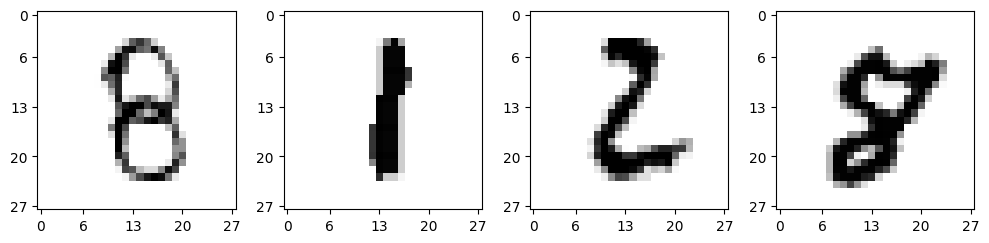

In [2]:
from IPython.display import display
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import sys
import time

# Read configuration file
with open("../config/user_config_file.json") as f:
    config_file = json.load(f)

# Import helper functions from src/utils_MNIST.py
sys.path.append(config_file["utils_location"])
import utils_MNIST

# General parameter(s)
DIGIT_TO_CLASSIFY = 8

# Read MNIST data
X_train, X_valid, X_test, y_train_digits, y_valid_digits, y_test_digits = utils_MNIST.prepare_MNIST_data_sets(config_file["MNIST_data_location"])

# Digit distribution in training, validation, and test data sets
stat_train = ["train"]+list(utils_MNIST.digit_label_statistics(y_train_digits))
stat_valid = ["valid"]+list(utils_MNIST.digit_label_statistics(y_valid_digits))
stat_test = ["test"]+list(utils_MNIST.digit_label_statistics(y_test_digits))
df_sample_stats= pd.DataFrame([stat_train, stat_valid, stat_test], columns=(["data", "sample size"]+[str(number) for number in range(10)]))

# Create 0/1 class labels based on the selected digit to classify
y_train = np.array(1*(y_train_digits==DIGIT_TO_CLASSIFY)).astype(int)
y_valid = np.array(1*(y_valid_digits==DIGIT_TO_CLASSIFY)).astype(int)

# Show statistics
display(df_sample_stats)

# Plot some sample numbers
idx_list = [23, 1, 9, 35]
fig, axes = plt.subplots(1,4, figsize=(10,160))
for ax, idx in zip(axes.flat, idx_list):
    ax.imshow(X_train[idx].reshape((28,28)), cmap=plt.cm.binary)
    ax.set_xticks([0, 6, 13, 20, 27])
    ax.set_yticks([0, 6, 13, 20, 27])
plt.tight_layout()
plt.show

#### STEP 2: Hyperparameter training

We define a logarithmically equidistance grid of hyperparameter values for $C$ ranging from $10^{-2}$ to $10$. A linear SVM is trained for each value of $C$ and its performance is evaluated on the validation set.

_Note_: Depending on computational resources, the execution of the cell below can take some time. 

In [ ]:
# Start iterations over hyperparameter grid
C_grid = np.logspace(-4, -1, num=10)
acc_list, para_l2_norm_list, comp_time = [], [], []
for counter, C_parameter in enumerate(C_grid):

    start_timer = time.time()

    # Estimate model
    SVM_model = SVC(C=C_parameter, kernel="linear", shrinking=False).fit(X_train, y_train)

    # Performance on validation data set
    y_pred = SVM_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    parameter_l2_norm = np.linalg.norm(SVM_model.coef_)
    elapsed_time =time.time()-start_timer

    # Append outcomes
    acc_list.append(accuracy), para_l2_norm_list.append(parameter_l2_norm), comp_time.append(elapsed_time)

    # Print progress
    print(f"Hyperparameter setting: {counter+1} out of {len(C_grid)} -- Hyperparameter: {C_parameter} -- Accuracy: {accuracy} -- Elapsed time: {elapsed_time}s")


# Generate overview plot
fig, ax1 = plt.subplots()
# Left axis
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy')
ax1.semilogx(C_grid, acc_list, color='k', linestyle="solid", label="Accuracy")
ax1.tick_params(axis='y')
# right axis
ax2 = ax1.twinx()
ax2.set_ylabel('Computation time (sec)')
ax2.semilogx(C_grid, comp_time, color='k', linestyle="dotted", label="L2 norm")
ax2.tick_params(axis='y')
fig.tight_layout()
plt.show()

#### STEP 3: Evaluate performance on the test data

In [ ]:
# Final hyperparameter value
selected_C_parameter = 1E-2

# Create 0/1 class labels based on the selected digit to classify
y_test = np.array(1*(y_test_digits==DIGIT_TO_CLASSIFY)).astype(int)

# Estimate model
selected_SVM_model = SVC(C=selected_C_parameter, kernel="linear", shrinking=False).fit(X_train, y_train)
y_pred_test = selected_SVM_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Inform user
print(f"Accuracy on test set: {test_accuracy*100}%")

#### STEP 4: Model interpretation through estimated coefficients

In [ ]:
# Reshape coefficients into image size
estimated_coef = selected_SVM_model.coef_.reshape((28, 28))

# Visualize estimated parameters
fig, ax = plt.subplots(1,1)
img = plt.imshow(estimated_coef)
ax.set_xticks([0, 6, 13, 20, 27])
ax.set_yticks([0, 6, 13, 20, 27])
cbar = plt.colorbar()
fig.tight_layout()